In [1]:
import numpy as np
import matplotlib.pyplot as plt
import simulator as sim
import random
import mogp_emulator

from testfunctions import arrays_to_arraymesh, arraymesh_to_arrays

plt.rcParams['figure.figsize'] = [15, 8]

random.seed(2022)

Choose points on which to build the emulator. Choose a 15x15 regular lattice to represent the simulator output.

In [2]:
true_params = [1.5745]

a = 0
b = 3
n = 10
x_locations = np.linspace(a, b, n)
y_locations = x_locations
t_month = 6
t_hour = 12

variable_params = arrays_to_arraymesh(x_locations, y_locations, t_month, t_hour)
X = variable_params[:, 0]
Y = variable_params[:, 1]

Run the simulator at the trianing points.

In [3]:
simulator = sim.Simulator(true_params, variable_params)

## Generate a set of simulation data
# calibration_points = [1.1, 1.15, 1.2, 1.5, 1.7, 1.8, 1.9]
calibration_points = [1.2, 1.5, 1.9]
calibration_params = np.array(calibration_points).reshape(-1, 1)
experiment1 = simulator.run(calibration_params)
print(experiment1.shape)
simulation_output = experiment1[:, -1]
regression_params = experiment1[:, [0,1,4]]

(300, 6)


## Fit a GP to model output

Fit the GP to the training data to build the emulator. No spectral/basis representation yet.

In [4]:
# This block takes approximately 40s on an M1 MacBook Air
gp = mogp_emulator.GaussianProcess(regression_params, simulation_output, nugget="fit")
gp = mogp_emulator.fit_GP_MAP(gp, n_tries=10)

Visually compare the emulator with the simulator output.

In [5]:
m = 200
x_locations_p = np.linspace(0, 3, m)
y_locations_p = x_locations_p
k_p = np.array(true_params)

prediction_points_gp = arrays_to_arraymesh(x_locations_p, y_locations_p, k_p)
prediction_points_sim = arrays_to_arraymesh(x_locations_p, y_locations_p, t_month, t_hour)

mean, var, _ = gp.predict(prediction_points_gp)
simulation_output_p = simulator.run(k_p.reshape(1,1), prediction_points_sim)



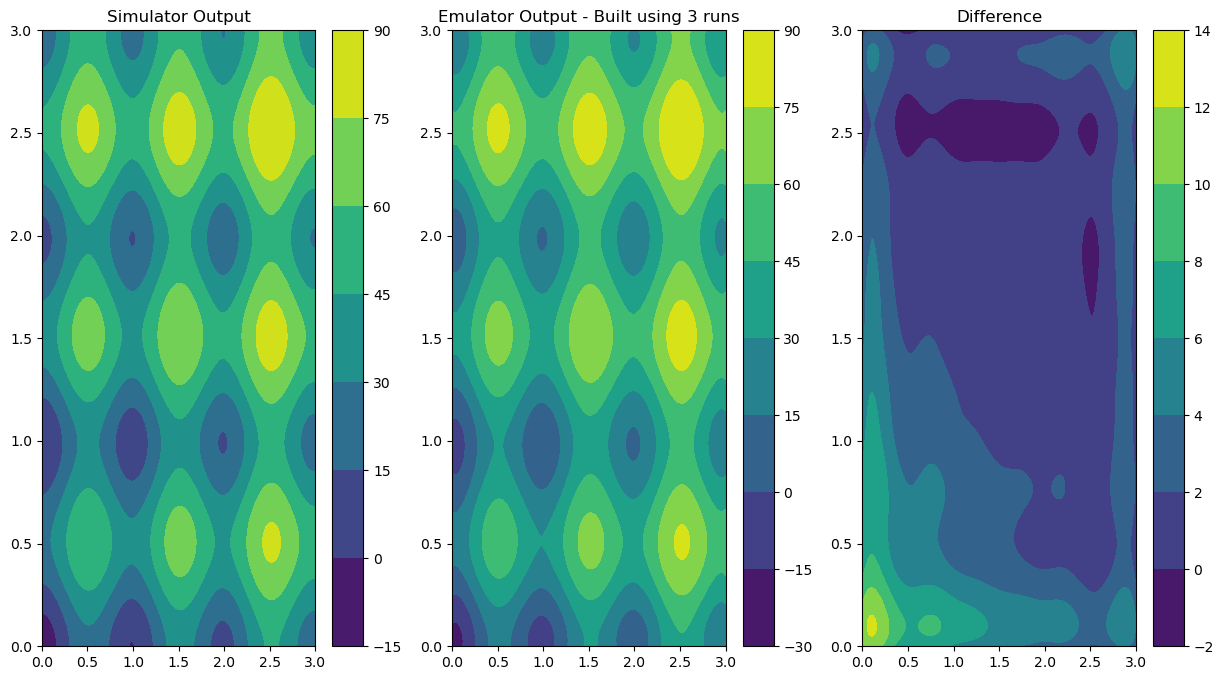

In [6]:
emulator_mean = arraymesh_to_arrays(mean, (m, m))
simulator_trueth = arraymesh_to_arrays(simulation_output_p[:,-1], (m, m))

fig, ax = plt.subplots(1, 3)
CS0 = ax[0].contourf(x_locations_p, y_locations_p, simulator_trueth)
fig.colorbar(CS0,ax=ax[0])
ax[0].title.set_text('Simulator Output')
CS1 = ax[1].contourf(x_locations_p, y_locations_p, emulator_mean)
fig.colorbar(CS1,ax=ax[1])
ax[1].title.set_text(f'Emulator Output - Built using {len(calibration_points)} runs')
CS2 = ax[2].contourf(x_locations_p, y_locations_p, simulator_trueth - emulator_mean)
fig.colorbar(CS2,ax=ax[2])
ax[2].title.set_text('Difference')
plt.show()

# Posterior Analysis using `Model.py`

In [7]:
# import MCMC
from Model import Model
from MCMC import MCMC

In [8]:
N = 30
rng = np.random.default_rng()
x_obs = a+(b-a)*rng.random(N)
y_obs = a+(b-a)*rng.random(N)
observation_variables = np.vstack([x_obs, y_obs, [t_month]*N, [t_hour]*N]).T

observations = simulator.get_observations(observation_variables)[:, -1]

In [9]:
xc  = regression_params[:, [0,1]]
t   = regression_params[:, 2].reshape(-1, 1)
y   = simulation_output
xf  = observation_variables[:, [0,1]]
z   = observations

y_mean = np.mean(y)
y_std = np.std(y)
y_normalised = ((y - y_mean)/y_std)

z_mean = np.mean(z)
z_std = np.std(z)
z_normalised = ((z - z_mean)/z_std)

xc_standardised = np.zeros_like(xc)
xc_min = np.min(xc, axis=0).flatten()
xc_max = np.max(xc, axis=0).flatten()
xf_standardised = np.zeros_like(xf)
xf_min = np.min(xf, axis=0).flatten()
xf_max = np.max(xf, axis=0).flatten()

for k in range(2):
    xc_standardised[:, k] = (xc[:, k] - xc_min[k])/(xc_max[k] - xc_min[k])
    xf_standardised[:, k] = (xf[:, k] - xf_min[k])/(xf_max[k] - xf_min[k])

t_min = np.min(t)
t_max = np.max(t)
t_standardised = (t - t_min)/(t_max - t_min)


In [10]:
initial_model = Model(
    xc  = xc_standardised, 
    t   = t_standardised,
    y   = y_normalised,
    xf  = xf_standardised,
    z   = z_normalised
)

total_iterations = 250

mcmc = MCMC(total_iterations, initial_model)
mcmc.run()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200


LinAlgError: Matrix is not positive definite

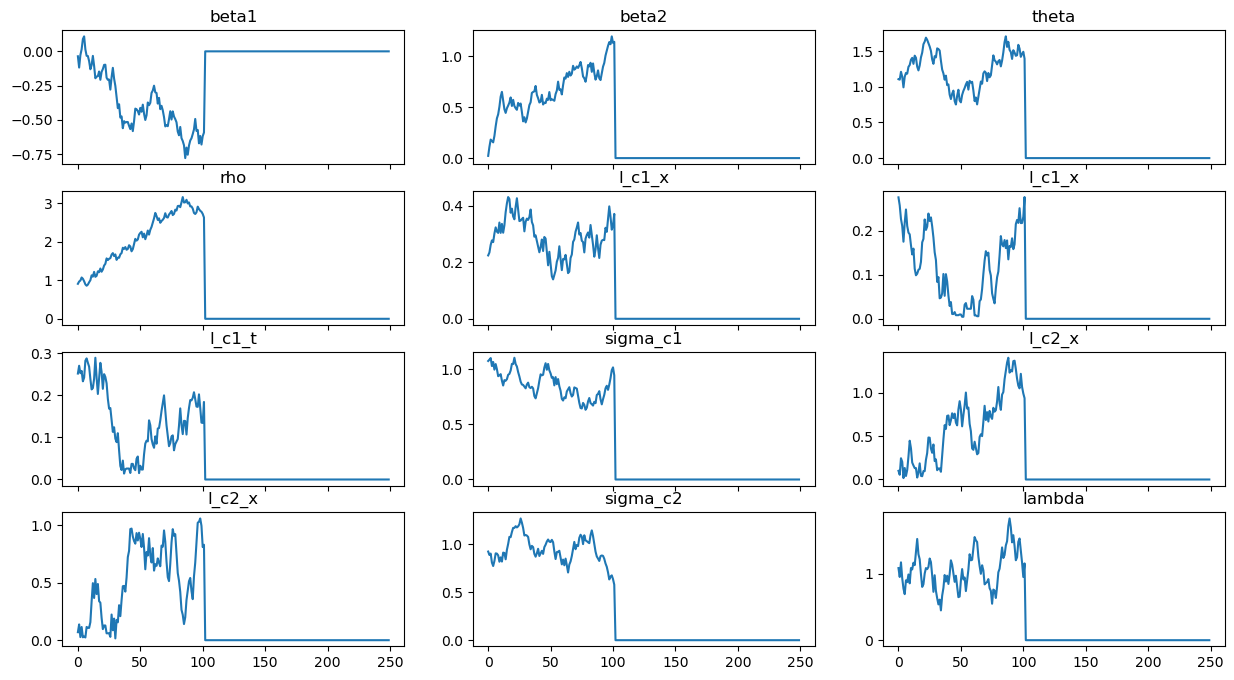

In [ ]:
fig, axes = plt.subplots(4, 3, sharex=True)
for i in range(4):
    for j in range(3):
        k = i*3 + j
        axes[i][j].plot(np.arange(0, total_iterations), mcmc.samples[:, k])
        axes[i][j].set_title(initial_model.get_model_params()['parameters'][k])
plt.show()